## Sampling a multivariate normal (D=50)

To show how NUTS is better suited for high dimension compared to Metropolis and Slice Sampling (similar to Gibbs Sampling), we will use each of the methods to sample from a (correlated) multivariate normal distribution with D=50. https://en.wikipedia.org/wiki/Multivariate_normal_distribution#/media/File:MultivariateNormal.png

In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [11]:
fac = 7
A = np.matrix([np.random.randn(D) + np.random.randn(1)*fac for i in range(D)])
A = A*np.transpose(A)
D_half = np.diag(np.diag(A)**(-0.5))
cov = D_half*A*D_half

In [12]:
cov

matrix([[ 1.00000000e+00,  7.47589415e-01, -7.23444914e-02, ...,
          7.79382600e-01, -7.59639004e-01, -8.04755554e-01],
        [ 7.47589415e-01,  1.00000000e+00, -3.71814980e-04, ...,
          8.65751854e-01, -8.57230687e-01, -8.82779691e-01],
        [-7.23444914e-02, -3.71814980e-04,  1.00000000e+00, ...,
         -1.16272860e-01,  1.69573268e-01,  6.88439150e-02],
        ...,
        [ 7.79382600e-01,  8.65751854e-01, -1.16272860e-01, ...,
          1.00000000e+00, -9.05331367e-01, -9.43232881e-01],
        [-7.59639004e-01, -8.57230687e-01,  1.69573268e-01, ...,
         -9.05331367e-01,  1.00000000e+00,  9.05412242e-01],
        [-8.04755554e-01, -8.82779691e-01,  6.88439150e-02, ...,
         -9.43232881e-01,  9.05412242e-01,  1.00000000e+00]])

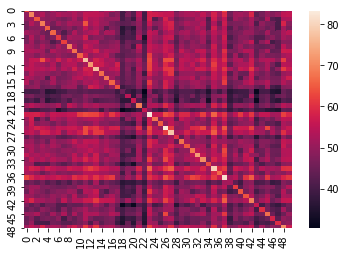

In [15]:
sns.heatmap(cov)

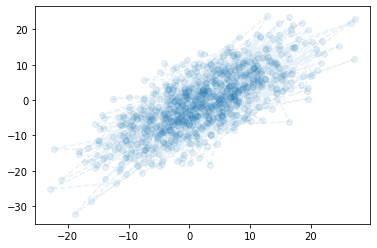

In [16]:
# set random seed, can be used for MCMC sampling as well
SEED = 123
np.random.seed(SEED)

# ---------------------------------------------------------------------------------------
# set up multivariate normal
# D = number of dimensions
D = 50

# set up means
mean_lower, mean_upper = -3, 3
means = np.random.rand(D) * (mean_upper - mean_lower) + mean_lower

# set up covariance matrix
lower_var, upper_var = 0, 2
cov = (np.random.rand(D,D) * (upper_var-lower_var) + lower_var)
cov = np.dot(cov, cov.transpose())

# ---------------------------------------------------------------------------------------
# draw 1000 independent samples and plot dimensions 0 and 1 
sample_size = 1000
X = np.random.multivariate_normal(means, cov, sample_size)

plt.plot(X[:,0], X[:,1], 'o--',alpha=0.1)

In [17]:
with pm.Model() as my_model:
    mv_normal = pm.MvNormal('mvn', mu=means, cov=cov, shape=D)
    
with my_model:
    tr_m = pm.sample(15000, step=pm.Metropolis(), discard_tuned_samples=True)
    tr_g = pm.sample(2500, step=pm.Slice(), discard_tuned_samples=True)
    tr_n = pm.sample(1000, step=pm.NUTS(), discard_tuned_samples=True)

Multiprocess sampling (4 chains in 4 jobs)
Metropolis: [mvn]
Sampling 4 chains: 100%|██████████| 62000/62000 [00:08<00:00, 6903.34draws/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
Slice: [mvn]
Sampling 4 chains: 100%|██████████| 12000/12000 [01:30<00:00, 131.89draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mvn]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:46<00:00, 56.31draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


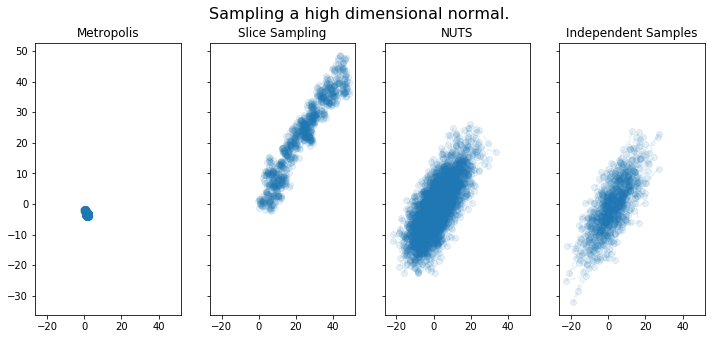

In [18]:
# plotting of trace results of first 2 dimensions
alpha = 0.1

fig, ax = plt.subplots(1,4,figsize=(12,5),sharex=True, sharey=True)
fig.suptitle('Sampling a high dimensional normal.', fontsize=16)

tr1 = tr_m["mvn"][7000:8000]
ax[0].plot(tr1[:,0], tr1[:,1], 'o--',alpha=alpha)
ax[0].title.set_text('Metropolis')
   
tr2 = tr_g["mvn"][0:1000]
ax[1].plot(tr2[:,0], tr2[:,1], 'o--',alpha=alpha)
ax[1].title.set_text('Slice Sampling')

tr3 = tr_n["mvn"]
ax[2].plot(tr3[:,0], tr3[:,1], 'o--',alpha=alpha)
ax[2].title.set_text('NUTS')


ax[3].plot(X[:,0], X[:,1], 'o--',alpha=0.1)
ax[3].title.set_text('Independent Samples')


#plt.tight_layout()
plt.savefig("plot_Multivariate_normal.pdf")